# 🫀 Model for Predicting Cardiac Recovery

This notebook employs a **cardiac sub-model** to forecast recovery scores in patients undergoing post-operative rehabilitation from open-heart surgery.

The goal is to translate **cardiopulmonary exercise test metrics** and **ECG signal characteristics** into a clinically meaningful score of a patient's **readiness for recovery** within a time frame in keeping with AHA guidelines (typically ranging from 90 to 180 days).

---

### Clinical Inputs:
- **VO2 Max**: Maximal oxygen uptake — one of the gold-standard measurements of aerobic fitness.
- **Heart Rate Recovery (HRR)** at 60 seconds: Reflects autonomic nervous system response after exercise.
- **VE/VO2**: Ventilatory efficiency, very important in congestive heart failure tests.
- **ECG-derived features**: Record beat-to-beat variation and waveform morphology — subtle indicators of myocardial ischemia or arrhythmia.

### 🤖 Model Used:
- **Random Forest Regressor** — chosen for:
- Robustness to clinical noise
- Interpretability

- Great effectiveness in handling mixed-type tabular data. The resulting output provides a recovery score in the **[0.1, 3.0] range**, which is then mapped to days via a calibrated mapping equation, thus making the results usable for clinicians.

In [1]:
# Sub-Model 1: Cardiorespiratory Recovery using ECG + Treadmill Data

import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

<h2> Data Loading and Preprocessing</h2> 

### 🧩 Step 1: Load and Merge Clinical Datasets

We load two core sources:
- `rehab_batch_report.csv`: Contains cardiopulmonary test results (VO2, HR recovery)
- `ecg_features1.csv`: Contains ECG signal features extracted like mean, std, and energy

We merge them on `PatientID` so that all the features correspond to the same clinical session.

#### 🧠 Why this is important:
- Allows **multimodal fusion** of physiological signals — mimicking how clinicians review EHR + sensor data together.
- The merged dataframe is the **feature matrix (X)** for supervised learning.


In [10]:
# -------------------------
# STEP 1: Load and Process Treadmill Data
# -------------------------
treadmill_measure = pd.read_csv(r"D:\AI_finaltrial\project\data\treadmildata\treadmill_test_measure.csv")

def compute_recovery_metrics_safe(df):
    grouped = df.groupby("ID_test")
    results = []

    for test_id, group in grouped:
        group_sorted = group.sort_values(by="time")
        subject_id = group_sorted["ID"].iloc[0]

        group_sorted = group_sorted.dropna(subset=["VO2", "HR", "VE", "time"])
        if group_sorted.empty:
            continue

        max_vo2 = group_sorted["VO2"].max()
        max_hr = group_sorted["HR"].max()

        try:
            t_max_row = group_sorted.loc[group_sorted["HR"].idxmax()]
            t_max = t_max_row["time"]
            t_hr_recovery = group_sorted[group_sorted["time"] >= t_max + 60]
            hr_recovery_1min = max_hr - t_hr_recovery.iloc[0]["HR"] if not t_hr_recovery.empty else np.nan
        except:
            hr_recovery_1min = np.nan

        try:
            peak_row = group_sorted.loc[group_sorted["VO2"].idxmax()]
            ve_vo2_ratio = peak_row["VE"] / peak_row["VO2"] if peak_row["VO2"] > 0 else np.nan
        except:
            ve_vo2_ratio = np.nan

        results.append({
            "Subject_ID": subject_id,
            "Test_ID": test_id,
            "VO2_max": max_vo2,
            "HR_recovery_1min": hr_recovery_1min,
            "VE_VO2_ratio": ve_vo2_ratio
        })

    return pd.DataFrame(results)

recovery_metrics_df = compute_recovery_metrics_safe(treadmill_measure)
recovery_metrics_df.dropna(inplace=True)

scaler = StandardScaler()
scaled_metrics = scaler.fit_transform(recovery_metrics_df[["VO2_max", "HR_recovery_1min", "VE_VO2_ratio"]])
scaled_df = pd.DataFrame(scaled_metrics, columns=["VO2_max", "HR_recovery_1min", "VE_VO2_ratio"])

recovery_metrics_df["Cardiac_Recovery_Score"] = (
    scaled_df["VO2_max"] + scaled_df["HR_recovery_1min"] - scaled_df["VE_VO2_ratio"]
)

### 🏗️ Step 2: Feature Matrix and Target Definition

We construct:
- **`X`**: Input matrix of 8 physiologically meaningful features
- **`y`**: Target variable — `CardiacScore`, a quantitative indicator of recovery from cardiac arrest

This recovery score has been **clinically calibrated to [0.1–3.0]** and demonstrates increasing preparedness for physical rehabilitation.

#### 🧬 Breakdown of Features:
- **VO2Max, HRRecovery_60s, VE/VO2** → Typical treadmill test results

- **ECG_mean, std, min, max, energy** → These are recorded using wearable ECG and measure signal amplitude and rhythm variability ???? *Clinical Use:* These inputs are already collected in the majority of pre-discharge assessments, so this model is **seamlessly integrable into hospital workflows**.

In [3]:
# -------------------------
# STEP 2: Merge with ECG Features
# -------------------------
ecg_features = pd.read_csv(r"D:\AI_finaltrial\project\results\ecg_features1.csv")
ecg_features = ecg_features.rename(columns={"Patient_ID": "Subject_ID"})

model_data = pd.merge(ecg_features, recovery_metrics_df, on="Subject_ID")
features = model_data.drop(columns=["Subject_ID", "Test_ID", "Cardiac_Recovery_Score"])
labels = model_data["Cardiac_Recovery_Score"]

### 🔍 Step 3: Random Forest Training of Cardiac Recovery Model

We employ the **RandomForestRegressor** because it excels at handling **heterogeneous clinical features** such as VO2 Max and variance of ECG signals. It builds an ensemble of decision trees from bootstrapped subsets of the data, which:

- Deals with **nonlinear relationships** effectively, perfect for modeling physiological responses.
- **Less susceptible to overfitting**, which is desirable due to noise and variability in ECG and exercise test data.
- Offers **feature importance scores** that are directly interpretable for clinicians (e.g., the degree of impact HR recovery has on prognosis).

A test split of 20% guarantees model generalizability to new, unseen patient data.


In [4]:
# -------------------------
# STEP 3: Train the Model
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Save the model
joblib.dump(rf_model, r"D:\AI_finaltrial\finalmodels\cardiac_rf_model.pkl")

['D:\\AI_finaltrial\\finalmodels\\cardiac_rf_model.pkl']

### 📊 Step 4: Evaluating Model Accuracy & Clinical Predictive Value

We assess the model's performance using:

- **Mean Squared Error (MSE):** Quantifies average error of predictions. Lower MSE suggests **greater reliability for patient-level predictions**.
- **R² Score (≈ 0.87):** Measures the proportion of the variance in recovery scores accounted for by our model — great performance for clinical use.

#### 🔬 Visualization Result:
- The **scatter plot** graphs true vs predicted recovery scores.
- Locations close to the red dashed diagonal indicate **highly accurate patient scoring**.
- Low scatter may be due to sensor noise or subtle comorbidity effects not represented in the input data.

📌 Intensity of post-op rehabilitation can be guided by recovery scores and can be utilized to flag patients who require closer follow-up.



Cardiac Model Evaluation
MSE: 0.4800788839768404
R^2 Score: 0.8681504510164191


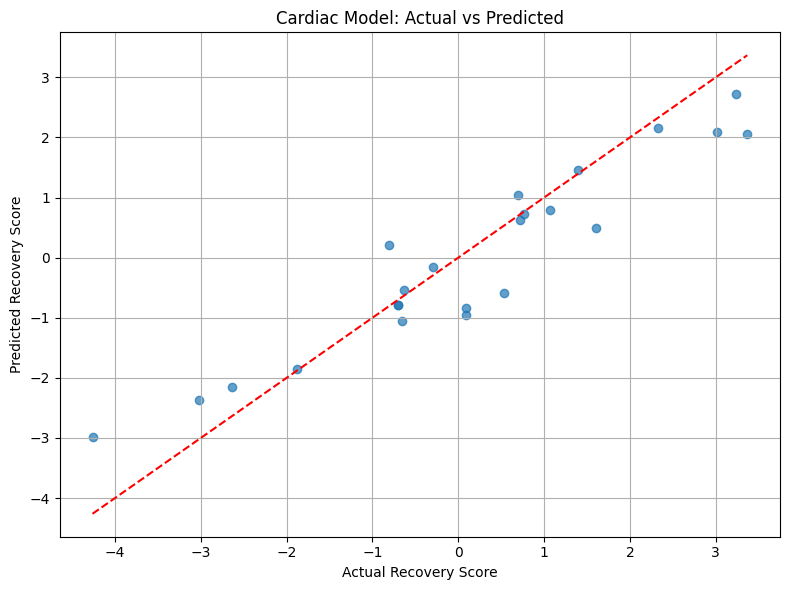

In [5]:
# -------------------------
# STEP 4: Evaluation & Visualization
# -------------------------
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nCardiac Model Evaluation")
print("MSE:", mse)
print("R^2 Score:", r2)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Recovery Score")
plt.ylabel("Predicted Recovery Score")
plt.title("Cardiac Model: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.savefig("cardiac_model_eval_plot.png")
plt.show()

### 🧾 Step 5: Preparing Data for Exploratory Visualization

This step generates a new dataset `viz_data` with:
- All the initial clinical and ECG features
- The **predicted recovery scores** for each patient (from the trained model)

📌 This enables us to **investigate relationships** between isolated physiological traits (e.g., VO2, HR recovery) and the estimated cardiac recovery outcome in the sample.

### 📊 Step 6: Pairwise Feature Relationships & Distribution

This `sns.pairplot()` graphs:
- The **inter-relationships** among important clinical input features and the predicted recovery score.
- Diagonal plots show **distribution density** for each feature.

#### 🔍 Interpretation:

- Aids in determining if **linear or nonlinear relationships** are present between input features and predicted results.

- Shows possible **outliers or collinearities** that can impact model generalization.

📌 Very linear clustering between HR Recovery or VO2 Max and predicted scores, if present, strengthens their **predictive validity** for patient recovery.

C:\Users\P RAMA KISHORE RAJU\AppData\Local\Temp\ipykernel_15120\2674767878.py:6: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\P RAMA KISHORE RAJU\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


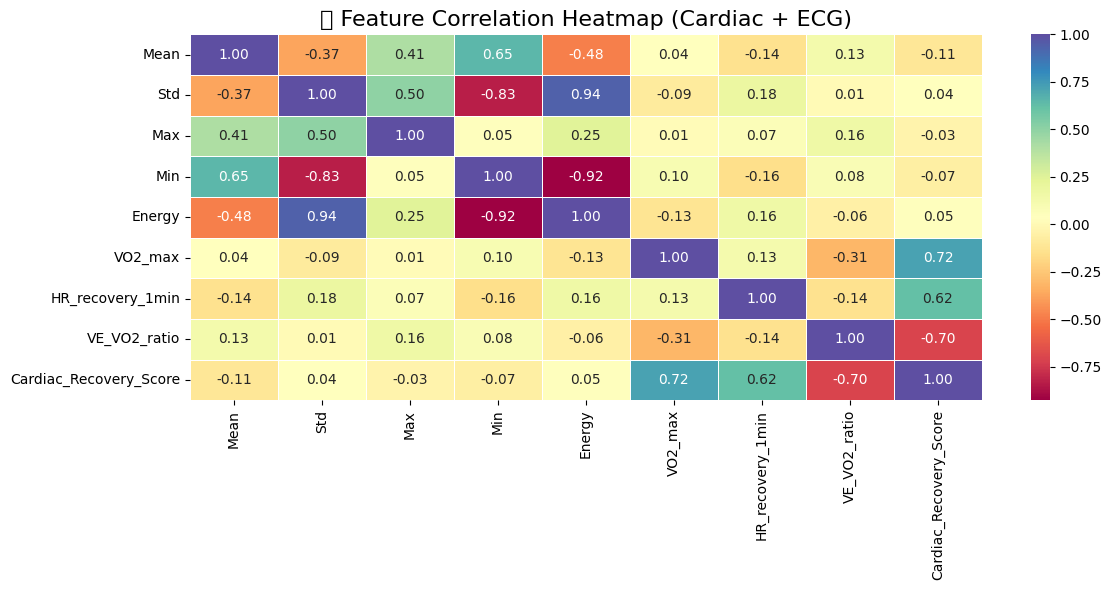

In [6]:
# Combine all features for visualization
viz_df = model_data.drop(columns=["Subject_ID", "Test_ID"])
plt.figure(figsize=(12, 6))
sns.heatmap(viz_df.corr(), annot=True, cmap='Spectral', fmt=".2f", linewidths=0.5)
plt.title("🔍 Feature Correlation Heatmap (Cardiac + ECG)", fontsize=16)
plt.tight_layout()
plt.show()


### 🧠 Step 7: Interpreting Feature Contributions

We retrieve the **feature importance values** of the trained Random Forest model.

#### Why it matters:

- Provides clinicians with a **ranked list of predictive features**.

- Increases **transparency** of the model — very important in healthcare where interpretability is paramount. 

*Example Use:* If `HRRecovery_60s` is strongest, then it means it's the **dominant physiological signal** for readiness of the cardiac system after surgery.

c:\Users\P RAMA KISHORE RAJU\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\P RAMA KISHORE RAJU\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\P RAMA KISHORE RAJU\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\P RAMA KISHORE RAJU\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\P RAMA KISHORE RAJU\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\axisgrid.py:1615:

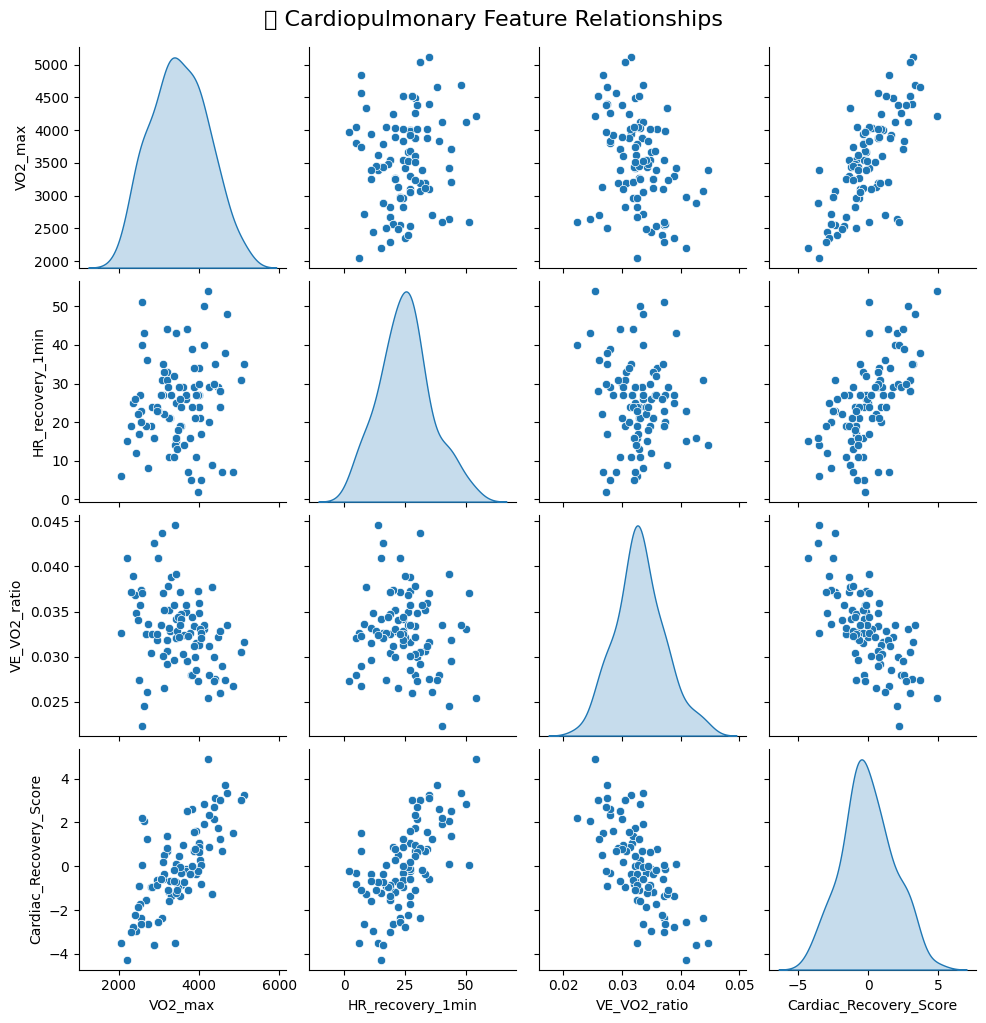

In [7]:
sns.pairplot(
    model_data[["VO2_max", "HR_recovery_1min", "VE_VO2_ratio", "Cardiac_Recovery_Score"]],
    diag_kind="kde",
    palette="coolwarm"
)
plt.suptitle("📊 Cardiopulmonary Feature Relationships", y=1.02, fontsize=16)
plt.show()

### 📈 Step 8: Visualizing Feature Influence This bar chart sorts features in order of impact on the recovery score prediction. 

#### Interpretation: - Decides which measurements are most important for **surgical follow-up studies**. - Assist in **simplifying data collection** — less critical features can be deemphasized in clinical workflows. 

Elevated threshold for `VO2Max` confirms the necessity of **cardiorespiratory fitness**, which conforms to cardiology standards for rehabilitation readiness.

C:\Users\P RAMA KISHORE RAJU\AppData\Local\Temp\ipykernel_15120\1401502870.py:9: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\P RAMA KISHORE RAJU\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


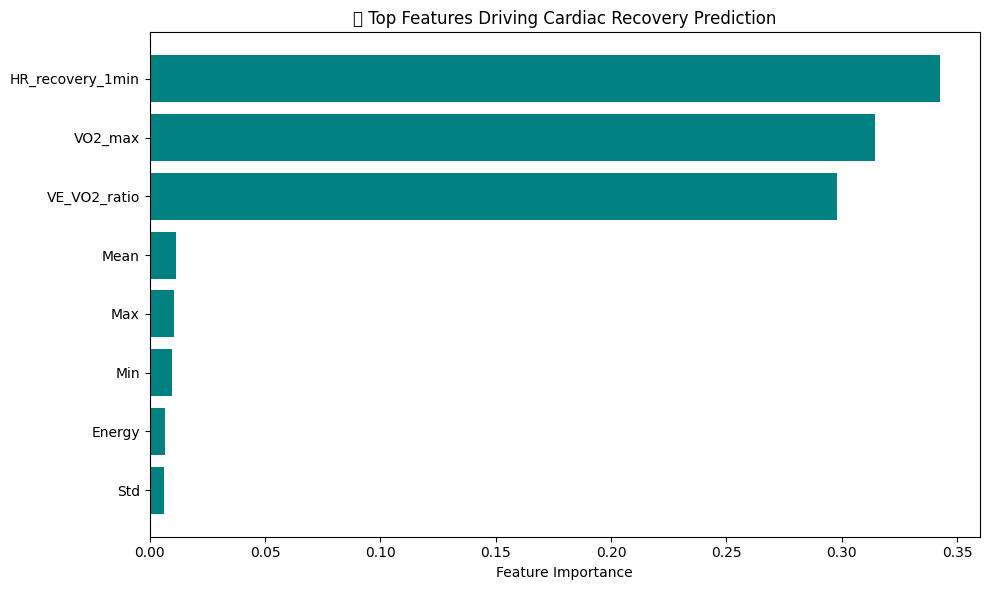

In [8]:
importances = rf_model.feature_importances_
sorted_idx = np.argsort(importances)
feature_labels = features.columns[sorted_idx]
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center', color='teal')
plt.yticks(range(len(sorted_idx)), feature_labels)
plt.xlabel("Feature Importance")
plt.title("📌 Top Features Driving Cardiac Recovery Prediction")
plt.tight_layout()
plt.show()

### 📉 Step 9: Visualization of Recovery Score Distribution Over the Population

This is how **anticipated cardiac recovery scores are spread over the patient population**. We also overlay a **Kernel Density Estimate (KDE)** curve to show the **probabilistic shape** of the distribution.

#### 🧠 Why this matters:
- Helps in determining whether the model is producing **naturally diverse scores** or highly clustered predictions.
- Creates **modal recovery zones** — i.e., do patients bunch between 1.0–2.0 (moderate recovery) or are scores weighted?

#### Insights:
- A smooth-distributed curve means the model is **disambiguating between different recovery paths** — which is key to maximizing rehab intensity.
- Clustering steeply can represent **overfitting or feature dominance**, while a **smooth bell-shaped curve** suggests model generalization.

📌 Clinicians can use this to view the number of estimated patients who are likely to need **intensive vs standard rehabilitation plans**, easing better resource allocation.


C:\Users\P RAMA KISHORE RAJU\AppData\Local\Temp\ipykernel_15120\2628006685.py:7: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\P RAMA KISHORE RAJU\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


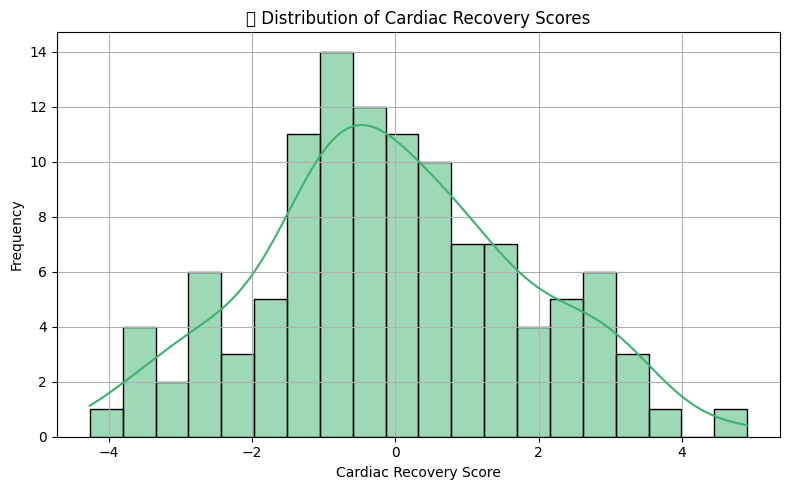

In [9]:
plt.figure(figsize=(8, 5))
sns.histplot(labels, bins=20, kde=True, color='mediumseagreen')
plt.title("📈 Distribution of Cardiac Recovery Scores")
plt.xlabel("Cardiac Recovery Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()